In [1]:
import numpy as np
import xarray as xr

import matplotlib.patches as patches
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable

Open and briefly analyze an example of synthetic-aperture radar (SAR) data, which is a form of radar used to create two or three dimensional reconstructions of objects. As part of the SUNRISE grant I am on with Rob, we are interested in using SAR data to identify submesoscale eddies in the northern Gulf of Mexico. SAR data can be particulary useful for this because some of the premium products contain very high spatial resolution compared to alternatives like satillite altimetry. 

The data structure can be quite complicated - and the example shown is Level 2 Sentinal 1 downloaded from https://search.asf.alaska.edu/#/. You will have to make an account to download the data, but it only takes a minute. Level 2 means the data contain derived geophysical variables from processed (and calibrated) data; see https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-1-sar/products-algorithms/level-2-algorithms/formatting for more information on the formatting and https://sentinel.esa.int/web/sentinel/user-guides/sentinel-1-sar/definitions for definitions.

The data consists of three components: Ocean Swell Spectra, Ocean Wind Field, and Radial Surface Velocity. Each of these components is on a different spatial grid - further complicating things. 

In [2]:
ds = xr.open_dataset('s1a-iw-ocn-vv-20200913t001819-20200913t001844-034333-03FDDC-001.nc')
ds

<xarray.Dataset>
Dimensions:                   (length: 26, oswAngularBinSize: 1, oswAzSize: 1, oswKxBinSize: 1, oswKyBinSize: 1, oswLag: 1, oswPartitions: 1, oswRaSize: 1, oswWavenumberBinSize: 1, owiAzSize: 167, owiIncSize: 154, owiPolarisation: 2, owiRaSize: 256, rvlAzSize: 233, rvlRaSize: 129, rvlSwath: 3)
Coordinates:
    oswPartitions             (oswAzSize, oswRaSize, oswAngularBinSize, oswWavenumberBinSize) float32 ...
Dimensions without coordinates: length, oswAngularBinSize, oswAzSize, oswKxBinSize, oswKyBinSize, oswLag, oswRaSize, oswWavenumberBinSize, owiAzSize, owiIncSize, owiPolarisation, owiRaSize, rvlAzSize, rvlRaSize, rvlSwath
Data variables:
    oswPolSpec                (oswAzSize, oswRaSize, oswAngularBinSize, oswWavenumberBinSize) float32 ...
    oswPolSpecNV              (oswAzSize, oswRaSize, oswAngularBinSize, oswWavenumberBinSize) float32 ...
    oswQualityCrossSpectraRe  (oswAzSize, oswRaSize, oswAngularBinSize, oswWavenumberBinSize) float32 ...
    oswQualityCrossSpectraIm  (oswAzSize, oswRaSize, oswAngularBinSize, oswWavenumberBinSize) float32 ...
    oswK                      (oswWavenumberBinSize) float32 ...
    oswPhi                    (oswAngularBinSize) float32 ...
    oswAzCutoff               (oswAzSize, oswRaSize) float32 ...
    oswRaCutoff               (oswAzSize, oswRaSize) float32 ...
    oswSpecRes                (oswAzSize, oswRaSize, oswAngularBinSize) float32 ...
    oswLon                    (oswAzSize, oswRaSize) float32 ...
    oswLat                    (oswAzSize, oswRaSize) float32 ...
    oswHs                     (oswAzSize, oswRaSize, oswPartitions) float32 ...
    oswHsNV                   (oswAzSize, oswRaSize, oswPartitions) float32 ...
    oswWl                     (oswAzSize, oswRaSize, oswPartitions) float32 ...
    oswDirmet                 (oswAzSize, oswRaSize, oswPartitions) float32 ...
    oswSnr                    (oswAzSize, oswRaSize) float32 ...
    oswAmbiFac                (oswAzSize, oswRaSize, oswPartitions) float32 ...
    oswIconf                  (oswAzSize, oswRaSize, oswPartitions) float32 ...
    oswLookSeparationTime     (oswAzSize, oswRaSize) float32 ...
    oswNrcs                   (oswAzSize, oswRaSize) float32 ...
    oswInten                  (oswAzSize, oswRaSize) float32 ...
    oswNv                     (oswAzSize, oswRaSize) float32 ...
    oswSkew                   (oswAzSize, oswRaSize) float32 ...
    oswKurt                   (oswAzSize, oswRaSize) float32 ...
    oswWindSpeed              (oswAzSize, oswRaSize) float32 ...
    oswWindDirection          (oswAzSize, oswRaSize) float32 ...
    oswEcmwfWindSpeed         (oswAzSize, oswRaSize) float32 ...
    oswEcmwfWindDirection     (oswAzSize, oswRaSize) float32 ...
    oswWindSeaHs              (oswAzSize, oswRaSize) float32 ...
    oswWaveAge                (oswAzSize, oswRaSize) float32 ...
    oswDepth                  (oswAzSize, oswRaSize) float32 ...
    oswNlWidth                (oswAzSize, oswRaSize) float32 ...
    oswLandFlag               (oswAzSize, oswRaSize) int8 ...
    oswLandCoverage           (oswAzSize, oswRaSize) float32 ...
    oswIncidenceAngle         (oswAzSize, oswRaSize) float32 ...
    oswHeading                (oswAzSize, oswRaSize) float32 ...
    oswGroundRngSize          (oswAzSize, oswRaSize) float32 ...
    oswAziSize                (oswAzSize, oswRaSize) float32 ...
    oswEllipsLength           (oswAzSize, oswRaSize, oswPartitions) float32 ...
    oswEllipsLengthStdDev     (oswAzSize, oswRaSize, oswPartitions) float32 ...
    oswEllipsWidth            (oswAzSize, oswRaSize, oswPartitions) float32 ...
    oswEllipsWidthStdDev      (oswAzSize, oswRaSize, oswPartitions) float32 ...
    oswGroupDir               (oswAzSize, oswRaSize, oswPartitions) float32 ...
    oswQualityFlagPartition   (oswAzSize, oswRaSize, oswPartitions) float32 ...
    oswQualityFlag            (oswAzSize, oswRaSize) float32 ...
    oswTotalHs                (oswAzSize, oswRaSiz

Plot the radial velocity as an example. It is defined as the 'ground range gridded difference between the measured Level-2 Doppler grid and the Level-1 calculated geometrical Doppler. The RVL component provides continuity of the ASAR Doppler grid. The RVL estimates are produced on a ground-range grid'. https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-1-sar/products-algorithms/level-2/products/surface-radial-velocity-component

In [3]:
ds.rvlRadVel

<xarray.DataArray 'rvlRadVel' (rvlAzSize: 233, rvlRaSize: 129, rvlSwath: 3)>
array([[[-1.400351, -1.287998, -1.238673],
        [-1.442123, -1.394057, -1.356552],
        ...,
        [      nan, -1.216011,       nan],
        [      nan, -1.24649 ,       nan]],

       [[-1.498794, -1.31114 , -1.25503 ],
        [-1.513372, -1.281517, -1.327041],
        ...,
        [      nan, -1.186336,       nan],
        [      nan, -1.247573,       nan]],

       ...,

       [[-1.224593, -1.030292, -1.130831],
        [-1.179935, -1.07662 , -1.132413],
        ...,
        [      nan, -1.043461,       nan],
        [      nan, -1.048708,       nan]],

       [[-1.140384, -0.986425, -1.002686],
        [-1.084894, -0.914699, -1.039286],
        ...,
        [      nan, -1.131988,       nan],
        [      nan, -1.098949,       nan]]], dtype=float32)
Dimensions without coordinates: rvlAzSize, rvlRaSize, rvlSwath
Attributes:
    units:      m/s
    long_name:  radial velocity

The dimensions 'rvlRadVel' and 'rvlRaSize' can be thought of as the X and Y coordinates, with rvlSwath containing the different grids that the velocity is measured on. Here, let's plot the second one because it doesn't touch land, therefore containing no NaNs, which will make things easier when plotting

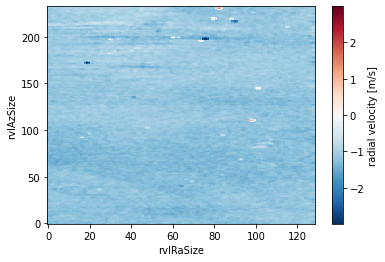

In [4]:
ds.rvlRadVel[:,:,1].plot()

We can make this plot better. Let's clean it up using cartopy to provide some geographical context.

In [11]:
lon = ds.rvlLon[:,:,1].data
lat = ds.rvlLat[:,:,1].data
vel = ds.rvlRadVel[:,:,1].values

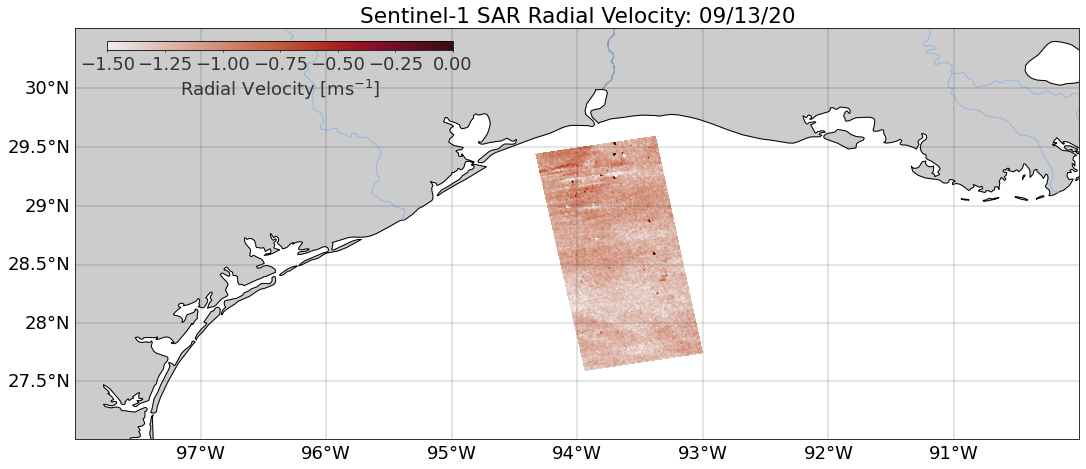

In [12]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=ccrs.Mercator())

mappable = ax.pcolormesh(lon, lat, vel, 
                       cmap = cmo.amp,
                       vmin = -1.5,
                       vmax = 0,
                       transform = ccrs.PlateCarree())

land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                edgecolor='face',
                                facecolor=cfeature.COLORS['land'])

states_provinces = cfeature.NaturalEarthFeature(
                   category='cultural',
                   name='admin_1_states_provinces_lines',
                   scale='10m',
                   facecolor='none')

gl = ax.gridlines(linewidth=0.4, color='black', alpha=0.5, linestyle='-', draw_labels=True)
ax.set_extent([-98, -90, 27, 30.5], ccrs.PlateCarree())
ax.add_feature(land_10m, facecolor='0.8')
ax.add_feature(states_provinces, edgecolor='0.2')
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='0.2')
ax.set_aspect('auto')

cax = fig.add_axes([0.09, 0.91, 0.32, 0.02]) 
cb = fig.colorbar(mappable, cax=cax, orientation='horizontal')
cb.set_label(r'Radial Velocity [ms$^{-1}$]', fontsize=18, color='0.2')
cb.ax.tick_params(labelsize=18, length=2, color='0.2', labelcolor='0.2')
ax.tick_params(axis='y', labelsize=18)

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.top_labels = False

ax.set_title('Sentinel-1 SAR Radial Velocity: 09/13/20')
plt.rcParams.update({'font.size': 18})

Let's look at another variable: the wind velocity measured from the SAR backscatter. It is a bit unclear what the reference height is but standard practice is 10 m above the surface

In [7]:
ds.owiWindSpeed

<xarray.DataArray 'owiWindSpeed' (owiAzSize: 167, owiRaSize: 256)>
array([[nan, 5.4, 5.2, ..., nan, nan, nan],
       [nan, 5.4, 5.3, ..., nan, nan, nan],
       [nan, 5.7, 5.4, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., 5.4, nan, nan],
       [nan, nan, nan, ..., 5.6, nan, nan],
       [nan, nan, nan, ..., 5.5, nan, nan]], dtype=float32)
Dimensions without coordinates: owiAzSize, owiRaSize
Attributes:
    units:          m/s
    long_name:      SAR Wind speed
    standard_name:  wind_speed

In [13]:
lon = ds.owiLon.data
lat = ds.owiLat.data
windspd = ds.owiWindSpeed.values

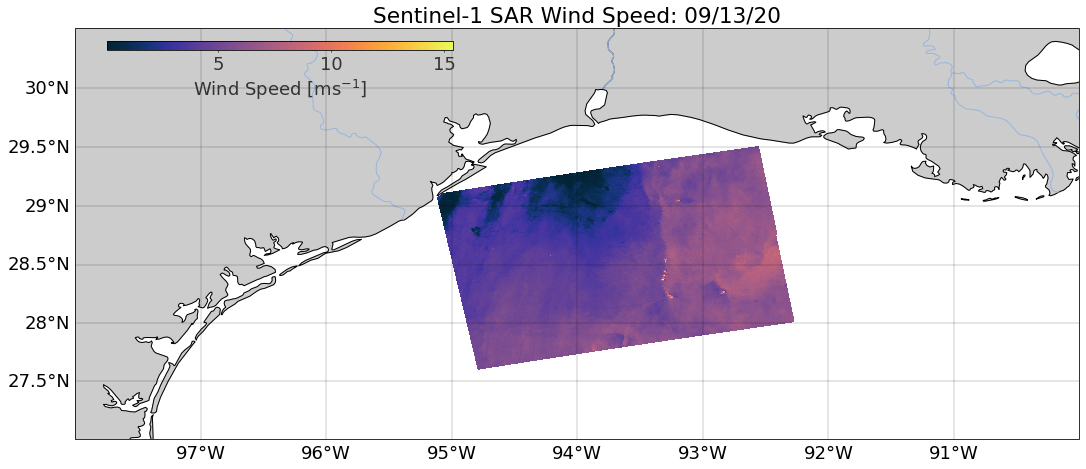

In [14]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=ccrs.Mercator())

mappable = ax.pcolormesh(lon, lat, windspd, 
                       cmap = cmo.thermal,
                       
                       transform = ccrs.PlateCarree())

gl = ax.gridlines(linewidth=0.4, color='black', alpha=0.5, linestyle='-', draw_labels=True)
ax.set_extent([-98, -90, 27, 30.5], ccrs.PlateCarree())
ax.add_feature(land_10m, facecolor='0.8')
ax.add_feature(states_provinces, edgecolor='0.2')
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='0.2')
ax.set_aspect('auto')

cax = fig.add_axes([0.09, 0.91, 0.32, 0.02]) 
cb = fig.colorbar(mappable, cax=cax, orientation='horizontal')
cb.set_label(r'Wind Speed [ms$^{-1}$]', fontsize=18, color='0.2')
cb.ax.tick_params(labelsize=18, length=2, color='0.2', labelcolor='0.2')
ax.tick_params(axis='y', labelsize=18)

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.top_labels = False

ax.set_title('Sentinel-1 SAR Wind Speed: 09/13/20')
plt.rcParams.update({'font.size': 18})

Basic statistics for the velocity fields are available (standard deviation), although we could easily derive them as well. This wraps up the introduction to opening ocean SAR data. 